In [138]:
import bs4
from bs4 import BeautifulSoup as bs
import pandas as pd
import scipy as sc
import numpy as np
import requests as req
from selenium import webdriver
PATH = 'C:\Program Files (x86)\chromedriver.exe'
from selenium.webdriver.common.keys import Keys
import time
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
from collections import Counter
from sklearn.decomposition import PCA
from collections import Counter
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

steam_pages = 85
metacritic_pages = 125 #from 125

In [5]:
count=0
# h = "https://store.steampowered.com/search"

h = "https://store.steampowered.com/search?category1=998"
prices = list()

# selenium - scrolling down on steam:
driver=webdriver.Chrome(PATH)
driver.get(h)
html = driver.find_element_by_tag_name('html')
time.sleep(1)
previous_height = driver.execute_script('return document.body.scrollHeight;')
for x in range (1,steam_pages):
# while True:
    driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
    time.sleep(1)
    new_height = driver.execute_script('return document.body.scrollHeight;')
    if new_height == previous_height:
        break
    previous_height = new_height
html_final=html.get_attribute('innerHTML')

C:\Users\liors\AppData\Local\Temp\ipykernel_7596\3028442127.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(PATH)
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\3028442127.py:8: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  html = driver.find_element_by_tag_name('html')


In [6]:
def load_soup_object(html_doc):
    soup = bs(html_doc,"html.parser")
    return soup

# crawling:
soup = load_soup_object(html_final)
inner_soup = soup.find( id ='search_resultsRows' )

game_title = soup.findAll('span' , attrs={'class':'title'})
game_release_date = soup.findAll('div' , attrs={'class':'col search_released responsive_secondrow'})
game_price = soup.findAll( 'div' , attrs = {'class':'search_price'})
game_review = soup.findAll( 'div' , attrs = {'class':'col search_reviewscore responsive_secondrow'})
Win_platform = soup.findAll( 'span' , attrs = {'class':'platform_img win'})

#get inner games links:
inner_games_list = list() 
for link in inner_soup.find_all('a'):
    inner_games_list.append(link.get('href'))


In [7]:
#get inner game html:
game_html = list()
game_developers = list()
game_details = list()
game_metascore = list()
game_storage = list()
clean_game_developers = list()
clean_game_details = list()
clean_game_metascore = list()
clean_game_storage = list()


i=0
for game in inner_games_list:
    game_html.append(req.get(game))
    game_soup = bs(game_html[i].text,"html.parser")
    game_developers.append(game_soup.find( id='developers_list' ))
    game_metascore.append(game_soup.find( id='game_area_metascore' ))
    game_storage.append(game_soup.findAll('div', attrs={'class':'game_area_sys_req'}))
    game_details.append(game_soup.find(id = 'genresAndManufacturer'))
    i+=1
    
#cleaning developers:
i=0
str_dev_list = [str(i) for i in game_developers]

for dev in game_developers:
    clean_dev = bs(str_dev_list[i] , "lxml").text
    clean_game_developers.append(clean_dev.strip())
    i+=1

#getting details with junk:
i=0
str_pub_list = [str(i) for i in game_details]

for pub in game_details:
    clean_details = bs(str_pub_list[i] , "lxml").text
    clean_game_details.append(clean_details.strip())
    i+=1

#getting metascore:
i=0
str_metascore = [str(i) for i in game_metascore]

for pub in game_metascore:
    clean_metascore = bs(str_metascore[i] , "lxml").text
    clean_game_metascore.append(clean_metascore.strip())
    i+=1    

#getting storage:
i=0
str_storage = [str(i) for i in game_storage]

for pub in game_storage:
    clean_storage = bs(str_storage[i] , "lxml").text
    clean_game_storage.append(clean_storage.strip())
    i+=1    



In [8]:
#creating the df:
df=pd.DataFrame({'GameTitles':game_title , 'ReleaseYear':game_release_date , 'Price':game_price ,'Developer':clean_game_developers,
                 'Publisher':clean_game_details , 'Genre':clean_game_details,'Franchise': clean_game_details,
                 'Storage(GB)':clean_game_storage , 'SteamPositivePrecent':game_review , 'SteamUserReviews':game_review ,'Metascore':clean_game_metascore})
df.index+=1

#creating clean by word function:
def clean_by_word(df_column , fromWord ,toWord , addons_list):
    new_list = list ()
    clean_new_list = list()
    for index, w in enumerate(df[df_column]):
        df[df_column][index+1].strip()
        word =  df[df_column][index+1]
        result = word.find(fromWord)
        word2 =  df[df_column][index+1][result:]
        new_list.append(word2)
        result2 = word2.find(toWord)
        clean_new_list.append(new_list[index][:result2])
        df[df_column][index+1] = clean_new_list[index]

    for addon in addons_list:
        df[df_column] = df[df_column].str.replace(addon, '')

In [9]:
# change dtype object >> str:
df['GameTitles'] = df['GameTitles'].astype(str)
df['ReleaseYear'] = df['ReleaseYear'].astype(str)
df['Price'] = df['Price'].astype(str)
df['SteamPositivePrecent'] = df['SteamPositivePrecent'].astype(str)
df['SteamUserReviews'] = df['SteamUserReviews'].astype(str)
df['Metascore'] = df['Metascore'].astype(str)


#remove useless chars:
spec_chars = ["!",'"',"#","%","&","(",")",
              "*","+",",","-","/",";","<",
              "=",">","?","@","[","\\","]","^","\n"
              "`","{","|","}","~" ,"™" ,"®"]
rev_price_addons = ["span" , "class" , "title" , "div" , "strike" , "col" 
                ,"search_price" , "search_released", "responsive_secondrow",
                "search_reviewscore" , "search_review_summary" , "positive" ,
                "data", "tooltip" , "html" , "\n" , "Positive" , "Very",
                "lt" , "br" ,"gt" , "Overwhelmingly" , "Mostly" , "mixed",
                "Mixed" , "of" , "discounted" , "style" , "or" , "888888" ,"user reviews f this game are",
                "This product has experienced" , ". one  me periods  ftopic review activity.",
                 "Based on your ", "preferences the review" , "s within these periods" ,
                 "    have been excluded" , "  from this products " , "Review Sce" , '< ="platfm_img win"></>'] 

html_addons = ["span" , "class" , "title" , "div" , "strike" , "col" 
                ,"search_price" , "search_released", "responsive_secondrow",
                "search_reviewscore" , "search_review_summary" ,
                "data" , "\t\t\t\t\t\t\t\t\t\n\n\nmetacritic\nRead" , "Critic Reviews","NA\n\nmetacritic\nNot yet reviewed.","Soon","e 16","ment","n","ouce","Ju","  A"] 

more_addons = ["Publisher:" , "\n" , "Genre:" , "Franchise:" , "Storage:" ,", Free to Play" , "Free to Play," ,", Early Access",'Atleast']

pos_rev_addons = ["\n" ,'<div class="col search_reviewscore responsive' ,'_secondrow"><span class="search_review_summary',
                    ' positive" data-tooltip-html="Very Positive&lt;br&gt;' , ' user reviews for this game are positive."></span></div>',
                    'positive" data-tooltip-html="Overwhelmingly','Positive&lt;br&gt;','mixed" data-tooltip-html="Mixed&lt;br&gt;', 'Storage',':',' ','fthe',".",
                    'positive" data-tooltip-html="Mostly ', ' user reviews for this game ','are positive.&lt;br&gt;&lt;br&gt;This product has experienced one or more periods of off-topic review activity.',
                    '  Based on your preferences, the reviews within these periods have been excluded from this product\'s Review Score."></span></div>','"',
                    ' user reviews for this software are positive.','></span></div>' ,'of the ' ,',' ,'_secondrow"></div>', "_secondrow></div>"," or " ,"+" ,"m"," user reviews for gaes in this bundle are positive.", "></span></div>",
                    "userreviewsforthisgaearepositive",".&lt;br&gt;&lt;br&gt;Thisproducthasexperiencedoneororeperiodsofoff-topicreviewactivity.Basedonyourpreferencesthereviewswithintheseperiodshavebeenexcludedfrothisp",
                    "roduct'sReviewScore.","&lt;br&gt;&lt;br&gt;Thisproducthasexperiencedoneororeperiodsofoff-topicreviewactivityBasedonyourpreferencesthereviewswithintheseperiodshavebeenexcludedfrothispro",
                    "duct'sReviewScore" ,"userreviewsforthissoftwarearepositive" ,'userreviewsforgaesinthisbundlearepositive','Atleast',
                    'Mindestens','userreviewsforthisvideoarepositive']                    

for char in spec_chars:
    df['GameTitles'] = df['GameTitles'].str.replace(char, '')
    df['ReleaseYear'] = df['ReleaseYear'].str.replace(char, '')
    df['Price'] = df['Price'].str.replace(char, '')
    df['SteamPositivePrecent'] = df['SteamPositivePrecent'].str.replace(char, '')

for addon in html_addons:
    df['GameTitles'] = df['GameTitles'].str.replace(addon, '')
    df['ReleaseYear'] = df['ReleaseYear'].str.replace(addon, '')
    df['Metascore'] = df['Metascore'].str.replace(addon, '')

for addon in rev_price_addons:
    df['Price'] = df['Price'].str.replace(addon, '')
    df['SteamPositivePrecent'] = df['SteamPositivePrecent'].str.replace(addon, '')

for posrev in pos_rev_addons:
    df['SteamUserReviews'] = df['SteamUserReviews'].str.replace(posrev, '')

#striping and cleaning columns:
for i in range(1,len(game_title)+1):
    df['GameTitles'][i] = df['GameTitles'][i].strip()
    df['ReleaseYear'][i] = df['ReleaseYear'][i].strip()
    df['Price'][i] = df['Price'][i].strip()
    df['SteamPositivePrecent'][i] = df['SteamPositivePrecent'][i].strip()

#creating nums list of int >> str
rate_list = list()
for i in range (0,101):
    rate_list.append(i)   

str_rate_list = [str(i) for i in rate_list]

#cleaning reviews:
i=1
for x in df['SteamPositivePrecent']:
    df['SteamPositivePrecent'][i]=x[:4].strip()
    if df['SteamPositivePrecent'][i] not in str_rate_list:
        df['SteamPositivePrecent'][i]='-1'
    i+=1
df['SteamPositivePrecent'] = df['SteamPositivePrecent'].astype(int)

#cleaning from details by word:
clean_by_word('Publisher' , 'Publisher:' , '\n\n', more_addons)
clean_by_word('Genre' , 'Genre:' ,'\n\n', more_addons)
clean_by_word('Franchise' , 'Franchise:' ,'\n\n', more_addons)

C:\Users\liors\AppData\Local\Temp\ipykernel_7596\462251291.py:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['GameTitles'] = df['GameTitles'].str.replace(char, '')
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\462251291.py:45: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['ReleaseYear'] = df['ReleaseYear'].str.replace(char, '')
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\462251291.py:46: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace(char, '')
C:\Users\liors\AppData\L

In [10]:

# converting Storage(GB) to numbers:

new_list = list ()
clean_new_list = list()
for index, w in enumerate(df['Storage(GB)']):
    df['Storage(GB)'][index+1].strip()
    word =  df['Storage(GB)'][index+1]
    result = word.find('Storage:')
    word2 =  df['Storage(GB)'][index+1][result+8:]
    new_list.append(word2)
    result2 = word2.find('B')
    clean_new_list.append(new_list[index][:result2+1])
    if (result >= 0):
        df['Storage(GB)'][index+1] = clean_new_list[index]
    if (word2 == 0 or result == -1):
        df['Storage(GB)'][index+1] = 0

Storage_addons = ['At least','Mindestens', '+','-','/',']','NaN','nan',
'[',':','*',' ']

for addon in Storage_addons:
    df['Storage(GB)'] = df['Storage(GB)'].str.replace(addon, '')

df['Storage(GB)'] = df['Storage(GB)'].astype(str)

for index, s in enumerate(df['Storage(GB)']):
    df['Storage(GB)'][index+1].strip()
    word =  df['Storage(GB)'][index+1]
    result = word.find('MB')
    if result >= 0:
        df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1][:-2].strip()
    else:
        df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1][:-2]
        df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1]+"000"

    if (df['Storage(GB)'][index+1] == 'n000'):
        df['Storage(GB)'][index+1] = 0

df['Storage(GB)'] = df['Storage(GB)'].astype(float)

for index, s in enumerate(df['Storage(GB)']):
    df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1]/1000



C:\Users\liors\AppData\Local\Temp\ipykernel_7596\308897833.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Storage(GB)'][index+1] = clean_new_list[index]
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\308897833.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Storage(GB)'][index+1] = 0
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\308897833.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Storage(GB)'] = df['Storage(GB)'].str.replace(

In [11]:
#clean ReleaseYear:
for index,x in enumerate(df['ReleaseYear']):
    counter = len(x)
    df['ReleaseYear'][index+1] = df['ReleaseYear'][index+1][counter-4:].strip()
    if df['ReleaseYear'][index+1] == '':
        df['ReleaseYear'][index+1] = 0

df['ReleaseYear'] = df['ReleaseYear'].astype(int)


C:\Users\liors\AppData\Local\Temp\ipykernel_7596\413551199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ReleaseYear'][index+1] = df['ReleaseYear'][index+1][counter-4:].strip()
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\413551199.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ReleaseYear'][index+1] = 0


In [12]:
#cleaning Genre:
new_list = list ()
for index, w in enumerate(df['Genre']):
    df['Genre'][index+1].strip()
    word =  df['Genre'][index+1]
    result = word.find(',')
    if result == -1:
         df['Genre'][index+1] = word
         continue
    if result >= 0:
        word2 =  df['Genre'][index+1][:result]
        df['Genre'][index+1] = word2       

C:\Users\liors\AppData\Local\Temp\ipykernel_7596\1953161038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre'][index+1] = word
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\1953161038.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre'][index+1] = word2


In [13]:
#cleaning Price:
new_list = list ()
for index, w in enumerate(df['Price']):
    df['Price'][index+1].strip()
    word =  df['Price'][index+1]
    result = word.find('₪')
    result3 = word.find('Free')
    if word == '':
        new_list.append('0')
        continue
    if result3 > -1:
         new_list.append('0')
         continue
    if result >= 0:
        word2 =  df['Price'][index+1][result:]
        result2 = word2[1:].find('₪')
        if result2 > -1:
            new_list.append(word2[1:result2+1])
        else:
            new_list.append(word2[1:])

for new_price in new_list:
    df['Price'] = new_list

df['Price'] = df['Price'].astype(float)


In [14]:
#cleaning PositiveReviews:
for index, r in enumerate(df['SteamUserReviews']):
    df['SteamUserReviews'][index+1].strip()
    word =  df['SteamUserReviews'][index+1]
    result = word.find('%')
    if result >= 0:
        df['SteamUserReviews'][index+1]=df['SteamUserReviews'][index+1][result+2:].strip()
    if r == '':
        df['SteamUserReviews'][index+1] = '0'
df['SteamUserReviews'] = df['SteamUserReviews'].astype(int)


C:\Users\liors\AppData\Local\Temp\ipykernel_7596\888192784.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SteamUserReviews'][index+1]=df['SteamUserReviews'][index+1][result+2:].strip()
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\888192784.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SteamUserReviews'][index+1] = '0'


In [15]:
h2 = 'https://www.metacritic.com/browse/games/release-date/available/pc/userscore'
i=0

driver=webdriver.Chrome(PATH)
driver.get(h2)
html = driver.find_element_by_tag_name('html')
html_final=html.get_attribute('innerHTML')

#metacritic crawling - getting list of urls:
soup = load_soup_object(html_final)


#getting pages links:
pages_links = soup.findAll('a' , attrs={'class':'page_num'})
pages_links_list = [str(i) for i in pages_links]

final_pages_list = list()
pages_link = pages_links_list[1][26:81]
for x in range (0,125):
    final_pages_list.append("https://www.metacritic.com"+pages_link+str(x))

cleaner_metaC_games = list()
cleaner_metaC_reviews = list()

#getting titles and ratings:
for x in range(0,metacritic_pages):
    # driver=webdriver.Chrome(PATH)
    driver.get('chrome://settings/clearBrowserData')
    driver.find_element_by_xpath('//settings-ui').send_keys(Keys.ENTER)
    driver.get(final_pages_list[x])
    html = driver.find_element_by_tag_name('html')
    html_final=html.get_attribute('innerHTML')
    soup = load_soup_object(html_final)

    metaC_game_title = soup.findAll('a' , attrs={'class':'title'})
    metaC_users_rating = soup.findAll('div' , attrs={'class':'clamp-score-wrap'})

    #cleaning titles:
    str_metaC_game_list = [str(i) for i in metaC_game_title]
    str_metaC_users_rating = [str(i) for i in metaC_users_rating]

    i=0
    for g in metaC_game_title:
        clean_metaC_game = bs(str_metaC_game_list[i] , "lxml").text
        cleaner_metaC_games.append(clean_metaC_game.strip())
        i+=1

    i=0
    for g in metaC_users_rating:
        clean_metaC_game = bs(str_metaC_users_rating[i] , "lxml").text
        cleaner_metaC_reviews.append(clean_metaC_game.strip())
        i+=1

#creating the new df:
meta_df=pd.DataFrame({'GameTitles':cleaner_metaC_games , 'metaUsersScore':cleaner_metaC_reviews })
meta_df.index+=1
meta_df['metaUsersScore'] = meta_df['metaUsersScore'].astype(float)



C:\Users\liors\AppData\Local\Temp\ipykernel_7596\2438880639.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(PATH)
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\2438880639.py:6: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  html = driver.find_element_by_tag_name('html')
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\2438880639.py:29: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  driver.find_element_by_xpath('//settings-ui').send_keys(Keys.ENTER)
C:\Users\liors\AppData\Local\Temp\ipykernel_7596\2438880639.py:31: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  html = driver.find_element_by_tag_name('html')


In [16]:
#Merging dataframes: 
df_copy = df.copy(deep=True)
df_copy = df.merge(meta_df , how='left' , on='GameTitles')
df_copy.index+=1

In [17]:

#creating a df copy and removing NaN:
df_copy = df_copy[df_copy['metaUsersScore'].notna()]
df_copy = df_copy[df_copy.Metascore != 'None']
df_copy = df_copy[df_copy.Metascore != 'Noe']
df_copy = df_copy[df_copy.Metascore != '']
df_copy = df_copy[df_copy['Storage(GB)'] != 0]
df_copy = df_copy[df_copy['ReleaseYear'] >= 1900]
df_copy = df_copy[df_copy['Storage(GB)'] <= 300]
df_copy = df_copy.drop_duplicates(subset='GameTitles')
df_copy = df_copy.reset_index()
df_copy = df_copy.drop(columns=['index'])
df_copy.index+=1

In [18]:
df_copy['Metascore'] = df_copy['Metascore'].astype(int)
df_copy['Genre'] = df_copy['Genre'].astype(str)

for index,w in enumerate(df_copy['Genre']):
    df_copy['Genre'][index+1]=df_copy['Genre'][index+1].strip()


C:\Users\liors\AppData\Local\Temp\ipykernel_7596\2361403810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Genre'][index+1]=df_copy['Genre'][index+1].strip()


In [19]:
df_copy.corr(method ='pearson')

,ReleaseYear,Price,Storage(GB),SteamPositivePrecent,SteamUserReviews,Metascore,metaUsersScore
ReleaseYear,1.000000,0.315972,0.101410,-0.093062,-0.260158,0.012353,-0.132974
Price,0.315972,1.000000,0.535602,-0.294709,-0.111899,0.117049,-0.172019
Storage(GB),0.101410,0.535602,1.000000,-0.338914,0.115934,0.125004,-0.265494
SteamPositivePrecent,-0.093062,-0.294709,-0.338914,1.000000,0.049359,0.335999,0.557047
SteamUserReviews,-0.260158,-0.111899,0.115934,0.049359,1.000000,0.173452,0.039961
Metascore,0.012353,0.117049,0.125004,0.335999,0.173452,1.000000,0.460434
metaUsersScore,-0.132974,-0.172019,-0.265494,0.557047,0.039961,0.460434,1.000000


Lets see the highly corolated plots created automatically:


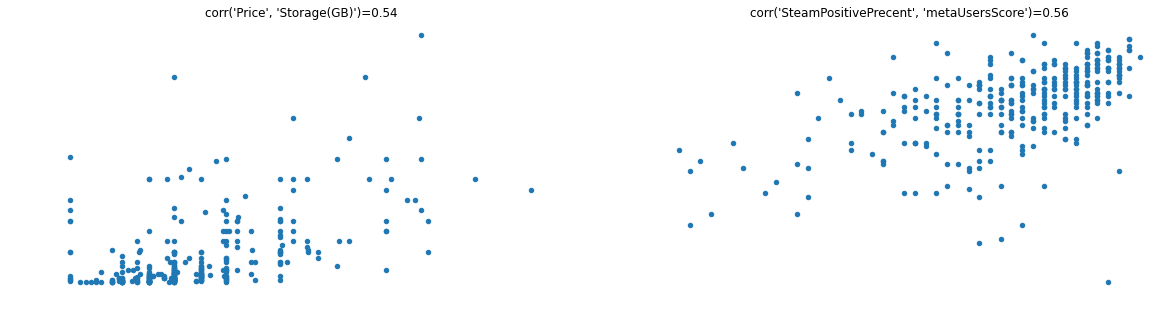

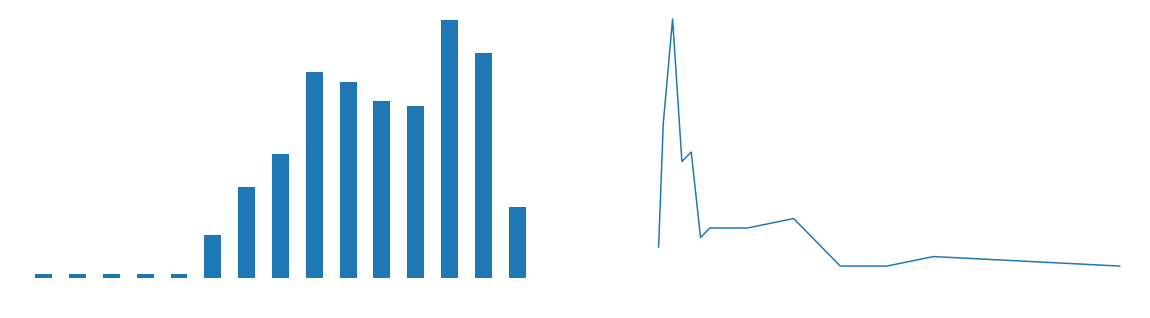

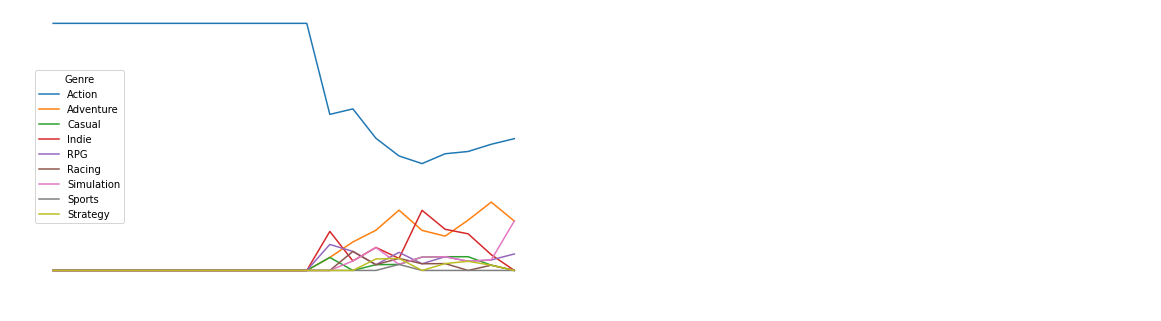

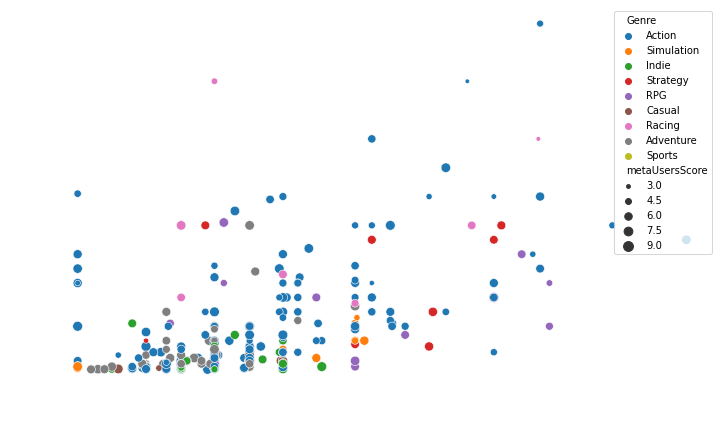

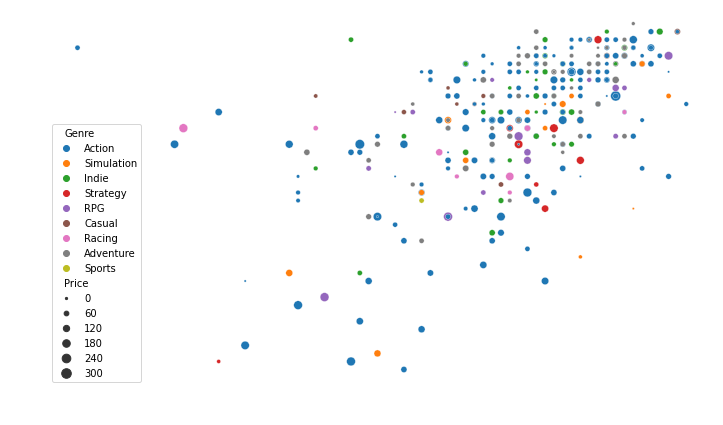

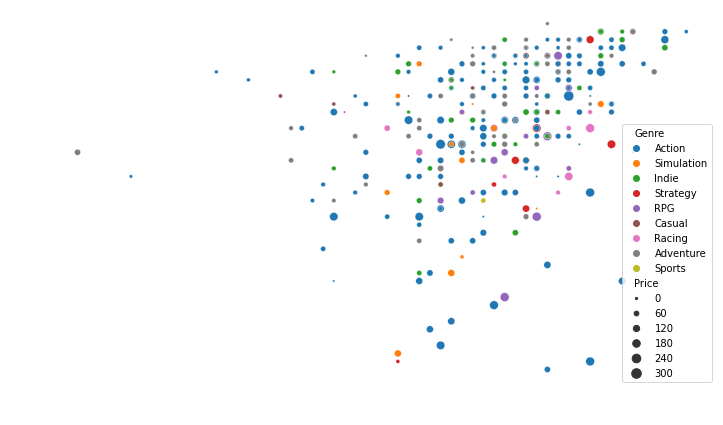

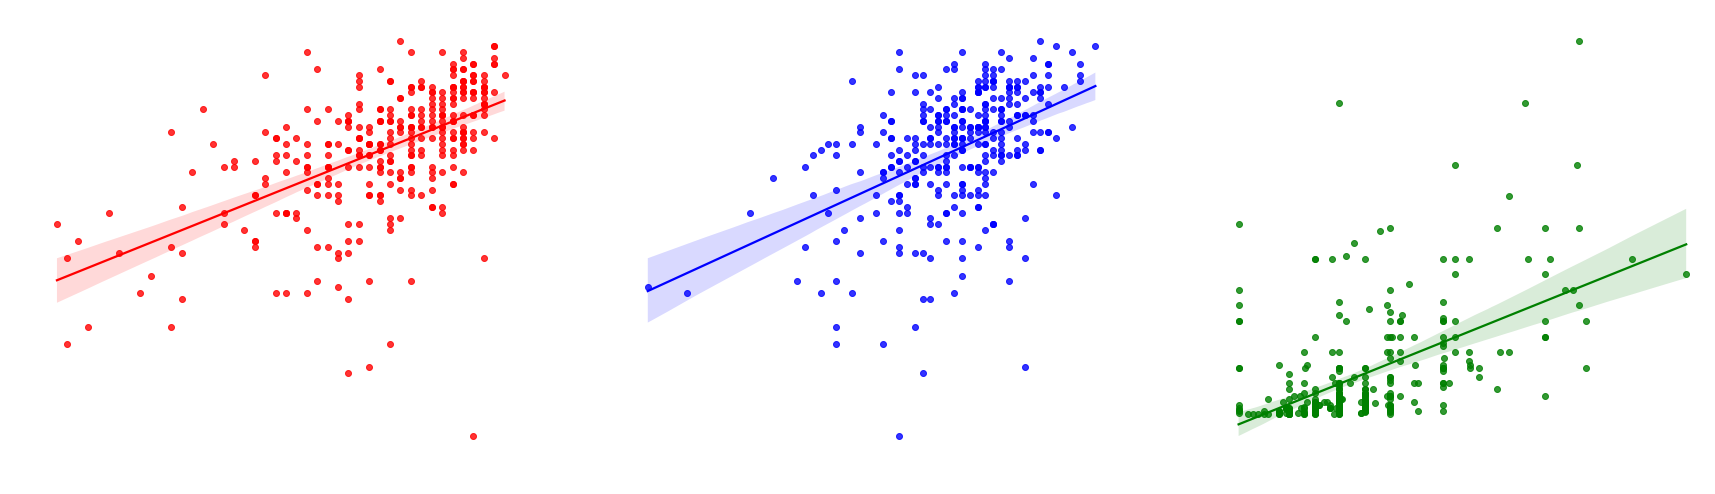

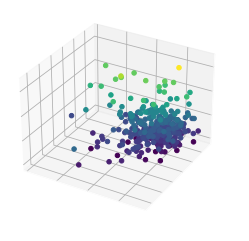

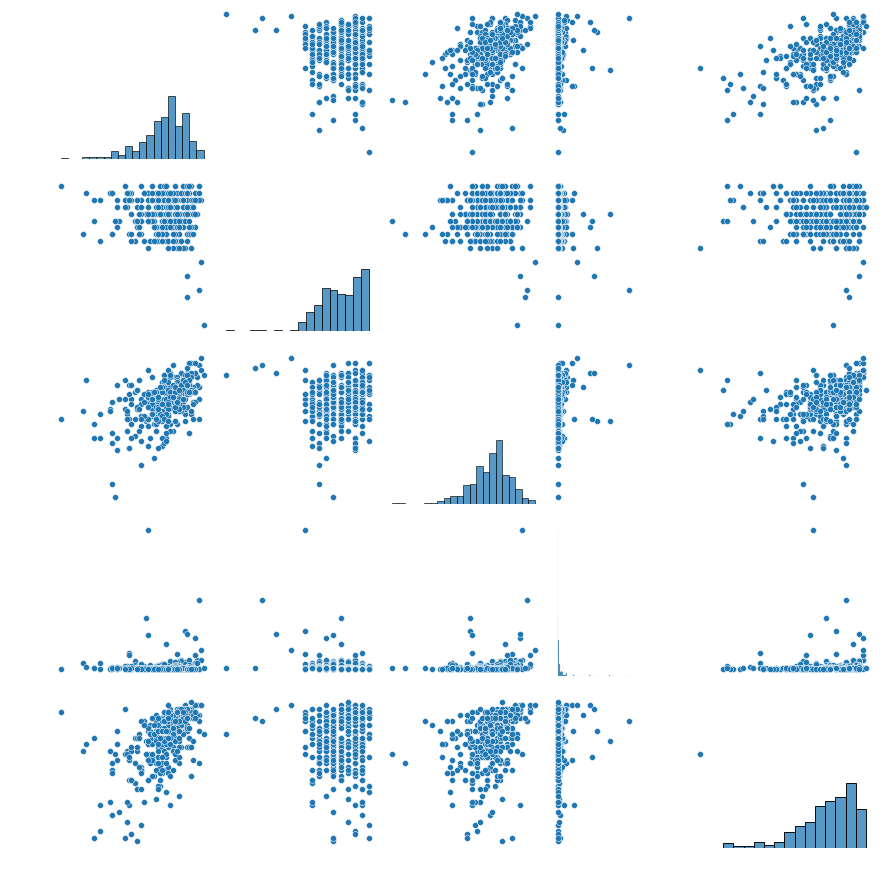

In [29]:
# plt functions:
def get_highly_correlated_cols(df):
    correlation=list()
    tuple_arr=list()
    
    list_of_cols=list()
    for col in df:
         list_of_cols.append(col)
            
    for i,col in enumerate(list_of_cols): 
        for j,col2 in enumerate(list_of_cols):   
            if col==col2:
                    continue
            else:
                corr = df[col].corr(method= "pearson" ,other=df[col2])
                if corr>=0.5 and (i,j) not in tuple_arr and i<j:
                    correlation.append(corr)
                    tuple_arr.append((i,j))
   
    return correlation,tuple_arr

def plot_high_correlated_scatters(df):
    correlation,tup= get_highly_correlated_cols(df)
    fig, axes=plt.subplots(1,len(correlation),figsize=(20,5))
    i=0
    for val in tup:    
        col_name1=df.columns[val[0]]
        col_name2=df.columns[val[1]]
        title = "corr('%s', '%s')=%4.2f"%(col_name1, col_name2, correlation[i])
        df.plot.scatter(x=col_name1,y=col_name2,ax=axes[i], title=title)
        i=i+1

def one_dim_plot(sr, plot_type, axis):
    sr.plot(kind=plot_type , ax=axis)

def get_frequent_elements(df, col_name, num_top_elements):
    topele = df[col_name].value_counts()[:num_top_elements]
    topele = topele.sort_index()
    return topele

def plot_frequent_elements(df, df_in_params):
    fig, axes = plt.subplots(1,df_in_params.shape[0], figsize=(20,5))
    for i in range(df_params.shape[0]):
        x=get_frequent_elements(df,df_params['col_name'][i],df_params['num_top_elements'][i])
        one_dim_plot(x,df_params['plot_type'][i],axes[i])

def cross_tabulation(df, col_name, other_col_name):
    ct1 = pd.crosstab(df[col_name],df[other_col_name],normalize='index')
    return ct1

def plot_cross_tabulation(df, col_names, other_col_name):
    i=0
    fig, axes = plt.subplots(1,2, figsize=(20,5))
    for val in col_names:
        new_df= cross_tabulation(df,val,other_col_name)
        new_df.plot(ax=axes[i])
        i=i+1

#---------------------------

print('Lets see the highly corolated plots created automatically:')
cols_for_correlations = ['ReleaseYear','Price','Storage(GB)','SteamPositivePrecent',
'SteamUserReviews','Metascore','metaUsersScore']    
plot_high_correlated_scatters(df_copy[cols_for_correlations])

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

# bar and line plots:
df_params = pd.DataFrame({'plot_type': ['bar', 'line'], 
                          'col_name': ['ReleaseYear', 'Storage(GB)'],'num_top_elements': [30,20]})
plot_frequent_elements(df_copy, df_params)

#crosstabulation:
plot_cross_tabulation(df_copy, ['ReleaseYear'],'Genre')


#colorful dots plot:
fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='Price' , y='Storage(GB)' , size='metaUsersScore' , hue='Genre',sizes=(5,100) ,data=df_copy)

fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='metaUsersScore' , y='SteamPositivePrecent' , size='Price' , hue='Genre',sizes=(5,100) ,data=df_copy)

fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='Metascore' , y='SteamPositivePrecent' , size='Price' , hue='Genre',sizes=(5,100) ,data=df_copy)

#nice new scatter plt
fig, axs = plt.subplots(ncols=3, figsize=(30,8))
sns.regplot(x="SteamPositivePrecent", y="metaUsersScore", data=df_copy, ax=axs[0], color='r')
sns.regplot(x="Metascore", y="metaUsersScore", data=df_copy, ax=axs[1], color='b')
sns.regplot(x="Price", y="Storage(GB)", data=df_copy, ax=axs[2], color='g')
axs[0].set_title('Steam Positive Precent and metascores Users Score (Top platforms)', fontsize=10, color='w')
axs[1].set_title('Critic Metascore and Metascores Users Score', fontsize=10, color='w')
axs[2].set_title('Price and Storage in (GB)', fontsize=10, color='w')
plt.show()

#3d plot:
ax = plt.axes(projection='3d')
xdata = df_copy['metaUsersScore']
ydata = df_copy['Metascore']
zdata = df_copy['Price']
plt.xlabel('Price')
plt.ylabel('Storage(GB)')
ax.scatter3D(xdata,ydata,zdata,c=zdata,depthshade=False)

#pariplot:
sns.pairplot(df_copy[['metaUsersScore','ReleaseYear','Metascore','SteamUserReviews','SteamPositivePrecent']])


In [181]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 1 to 332
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameTitles            332 non-null    object 
 1   ReleaseYear           332 non-null    int32  
 2   Price                 332 non-null    float64
 3   Developer             332 non-null    object 
 4   Publisher             332 non-null    object 
 5   Genre                 332 non-null    object 
 6   Franchise             332 non-null    object 
 7   Storage(GB)           332 non-null    float64
 8   SteamPositivePrecent  332 non-null    int32  
 9   SteamUserReviews      332 non-null    int32  
 10  Metascore             332 non-null    int32  
 11  metaUsersScore        332 non-null    float64
dtypes: float64(3), int32(4), object(5)
memory usage: 26.1+ KB


Coefficients: [-0.09539071  0.03732175 -0.01622212 -0.15622713  0.35039477 -0.0259321
  0.29323159 -0.00465274 -0.0176839  -0.09672721]
Intercept: -0.014369017693073303
Mean squered error (MSE): 0.55
Coefficient of determination (R^2): 0.53 / 1.0
True Score: 0.5293319530908359


c:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='metaUsersScore'>

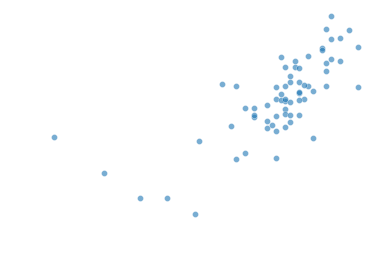

In [191]:
final_df = df_copy.copy(deep=True)
final_df = final_df.drop(columns=['GameTitles','Developer','Publisher','Franchise'])
le=LabelEncoder()
final_df['Genre'] = le.fit_transform(final_df['Genre'])
#----------------------------------
#normalizinig the new df:
normalized_df=(final_df-final_df.mean())/final_df.std()
normalized_df

#fixing the final score:
normalized_df['critic_users_ratio']=normalized_df['metaUsersScore']/normalized_df['Metascore']
normalized_df['metaUsersScore_Storage_ratio']=normalized_df['metaUsersScore']/normalized_df['Storage(GB)']
normalized_df['metaUsersScore_Genre_ratio']=normalized_df['metaUsersScore']/normalized_df['Genre']

#creating the prediction:
x_df = normalized_df.drop(columns=['metaUsersScore'])
y_df = normalized_df['metaUsersScore']

l = LinearRegression()
x_train , x_test , y_train , y_test = train_test_split(x_df,y_df, test_size=0.2 , random_state = 4)
l.fit(x_train,y_train)
pred = l.predict(x_test)

print('Coefficients:',l.coef_)
print('Intercept:',l.intercept_)
print('Mean squered error (MSE): %.2f' % mean_squared_error(y_test , pred))
print('Coefficient of determination (R^2): %.2f' % r2_score(y_test, pred),'/ 1.0')
print('True Score:',l.score(x_test,y_test))
#final plot:
sns.scatterplot(y_test,pred,alpha=0.6)

#----------------------------------------------


In [174]:
l.score(x_test,y_test)

0.3839749550031054